In [1]:
import numpy as np
import random
import sklearn
from sklearn import metrics, ensemble, preprocessing
from matplotlib import pyplot as plt
from scipy.stats import norm
import os
import datetime

np.set_printoptions(suppress=True)
np.random.seed(100)
random.seed(100)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
import tensorflow as tf
from tensorflow import keras

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

print(tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')))

# tf.compat.v1.disable_eager_execution()
tf.config.run_functions_eagerly(True)

2023-05-14 15:19:14.705091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1
GPU available: 1


2023-05-14 15:19:16.333524: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-14 15:19:16.539978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 15:19:16.541835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2023-05-14 15:19:16.541923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-14 15:19:16.548498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-14 15:19:16.549045: I tensorflow/stream_executor/platf

In [4]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

In [5]:
NOTES_QTY = 20
NOTE_PARAMS = 4
LEFT_PAD = 1
RIGHT_PAD = 1
TEST_LEN = 10000

MAX_NOTE_INT = 24
MAX_NOTE_DT = 5

In [6]:
def prepare(dset):    
    dt = dset[..., 3].copy()
    dset[..., 3] = dset[..., 1] / dset[..., 3]
    dset[..., 1] = dt
    
    # 0 - tone
    # 1 - dt
    # 2 - velocity
    # 3 - legato
    
    return dset

In [7]:
def make_relative(dset):
    dset[..., 0] = np.diff(dset[..., 0], axis=1, prepend=0)
    dset[..., 2] = np.diff(dset[..., 2], axis=1, prepend=0)
    
    first_notes = np.delete(dset[:, 0, :], obj=0, axis=-1)
    dset = np.delete(dset, obj=0, axis=1)
    
    return dset, first_notes

In [8]:
def filter_outliers(dset, fnotes):
    cond = np.logical_and.reduce((
        np.all(np.abs(dset[..., 0]) <= MAX_NOTE_INT, axis=1),
        np.all(dset[..., 1] > 0, axis=1),
        np.all(dset[..., 1] <= MAX_NOTE_DT, axis=1),
        np.all(dset[..., 3] > 0, axis=1),
        # np.sqrt(np.mean(np.square(dset[..., 2]), axis=1)) > 5
        
        fnotes[..., 0] <= MAX_NOTE_DT,
        fnotes[..., 2] > 0
    ))
    
    dset = dset[cond]
    fnotes = fnotes[cond]
    
    return dset, fnotes
    
def normalize(dset, fnotes, params=None):
    dset = dset.copy()
    
    if params is not None:
        tone_mean, tone_std, dt_max, vel_mean, vel_std, fvel_mean, fvel_std = params
    else:
        tone_mean = np.mean(dset[..., 0])
        tone_std = np.std(dset[..., 0])
    
        dt_max = np.max(np.concatenate((dset[..., 1], fnotes[..., 0]), axis=None))
    
        vel_mean = np.mean(dset[..., 2])
        vel_std = np.std(dset[..., 2])
        
        # leg_max = np.max(np.concatenate((dset[..., 3], fnotes[..., 2]), axis=None))
        
        fvel_mean = np.mean(fnotes[..., 1])
        fvel_std = np.std(fnotes[..., 1])
    
    dset[..., 0] = (dset[..., 0] - tone_mean) / tone_std
    dset[..., 1] = dset[..., 1] / dt_max
    dset[..., 2] = (dset[..., 2] - vel_mean) / vel_std
    # dset[..., 3] = dset[..., 3] / leg_max
    dset[..., 3] = dset[..., 3] - 1
    
    fnotes[..., 0] = fnotes[..., 0] / dt_max
    fnotes[..., 1] = (fnotes[..., 1] - fvel_mean) / fvel_std
    # fnotes[..., 2] = fnotes[..., 2] / leg_max
    fnotes[..., 2] = fnotes[..., 2] - 1
    
    if params is not None:
        return dset, fnotes
    else:
        return dset, fnotes, (tone_mean, tone_std, dt_max, vel_mean, vel_std, fvel_mean, fvel_std)
    

In [9]:
def mess_n(lines, n, param):
    mu, std = norm.fit(lines[..., param].flatten())
    l = list(range(NOTES_QTY - 1))
    
    for line in lines:
        idxs = random.sample(l, n)
        for idx in idxs:
            line[idx][param] = np.random.normal(mu, std)
            
def mess(test, param):
    test_messed = test.copy()
    for i in range(NOTES_QTY - 1):
        mess_n(test_messed[i * TEST_LEN: (i + 1) * TEST_LEN], i+1, param)
        
    return test_messed

            
def mess_fnotes(test, param):
    test = test.copy()
    mu, std = norm.fit(test[..., param].flatten())
    
    test[..., param] = np.random.normal(mu, std, len(test))
    
    return test

In [10]:
dset = np.load(PROJECT_PATH + 'data/dset20.npy')
tdset = np.load(PROJECT_PATH + 'data/test_dset20.npy')

In [11]:
dset[np.min(dset[..., 1], axis=1) == 0].shape

(7, 20, 4)

In [12]:
dset = prepare(dset)
tdset = prepare(tdset)

In [13]:
dset, fnotes = make_relative(dset)
print(dset.shape)

tdset, tfnotes = make_relative(tdset)
print(tdset.shape)

(6748376, 19, 4)
(2000600, 19, 4)


In [14]:
dset, fnotes = filter_outliers(dset, fnotes)
print(dset.shape, fnotes.shape)

tdset, tfnotes = filter_outliers(tdset, tfnotes)
print(tdset.shape, tfnotes.shape)

(6286105, 19, 4) (6286105, 3)
(1935576, 19, 4) (1935576, 3)


In [15]:
dset, fnotes, params = normalize(dset, fnotes)
print(params)

tdset, tfnotes = normalize(tdset, tfnotes, params)

(0.00077624, 4.1691732, 5.0, 0.018479822, 11.002829, 70.99861, 15.916798)


In [16]:
tdset = tdset[:NOTES_QTY * TEST_LEN]
tfnotes = tfnotes[:NOTES_QTY * TEST_LEN]
print(tdset.shape)

vel_mess = mess(tdset, 2)
print('.', end='')
leg_mess = mess(tdset, 3)
print('.', end='')

fvel_mess = mess_fnotes(tfnotes, 1)
print('.', end='')
fleg_mess = mess_fnotes(tfnotes, 2)
print('.', end='')

(200000, 19, 4)
....

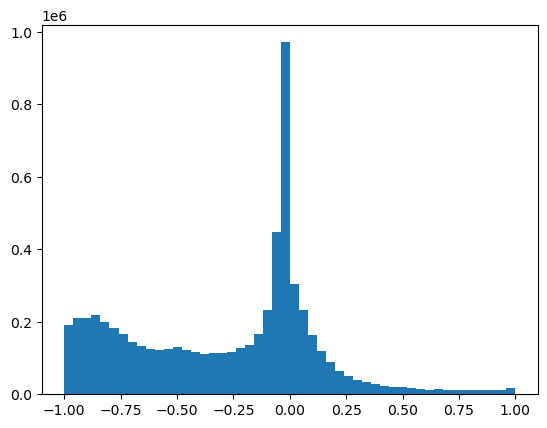

In [17]:
plt.hist(fnotes[..., 2].flatten(), bins=50)
plt.show()

In [18]:
train_flatten = np.reshape(dset, (dset.shape[0], dset.shape[1] * dset.shape[2]))
train = np.concatenate((fnotes, train_flatten), axis=1)

test_flatten = np.reshape(tdset, (tdset.shape[0], tdset.shape[1] * tdset.shape[2]))
test = np.concatenate((tfnotes, test_flatten), axis=1)

print(f'train: {train.shape}, test: {test.shape}')

train: (6286105, 79), test: (200000, 79)


In [19]:
vel_mess = np.reshape(vel_mess, (vel_mess.shape[0], vel_mess.shape[1] * vel_mess.shape[2]))
vel_mess = np.concatenate((tfnotes, vel_mess), axis=1)

leg_mess = np.reshape(leg_mess, (leg_mess.shape[0], leg_mess.shape[1] * leg_mess.shape[2]))
leg_mess = np.concatenate((tfnotes, leg_mess), axis=1)

fvel_mess = np.concatenate((fvel_mess, test_flatten), axis=1)

fleg_mess = np.concatenate((fleg_mess, test_flatten), axis=1)

In [20]:
print(train[0][0:3], train[0][3:], sep='\n')

[ 0.05833333 -0.8794867  -0.03124994]
[-0.00018619  0.15442708  0.5436348  -0.03541315 -1.1994648   0.49427086
 -0.819651   -0.13435197 -0.00018619  0.4611979  -0.09256528 -0.24505925
 -1.9190319   0.54375     0.18009189 -0.36685824  1.6788038   0.30390626
 -0.54699385  0.40616965 -4.5574446   0.30572918  0.5436348  -0.59540033
  1.6788038   0.12890625  0.08920617 -0.0242424   1.1990924   0.8942708
  0.18009189 -0.7431567  -0.24004191  0.3390625   0.18009189 -0.02457756
  0.23966953  0.12317709 -0.183451   -0.0930233   0.23966953  0.3296875
  0.9071777  -0.01816744  0.23966953  0.17083333  0.08920617 -0.2713415
 -2.638599    0.11796875 -0.09256528  0.02649009  4.557072    0.37421876
  0.5436348  -0.1572721  -2.8784547   0.46614584 -1.0923082  -0.16424584
  0.4795252   0.43541664 -1.3649653  -0.27631575 -2.1588876   0.27291667
 -1.0014224  -0.4608779  -0.24004191  0.26744792 -0.54699385 -0.40019476
  1.1990924   0.1484375   0.18009189 -0.42631578]


# Models

In [21]:
INPUT_SHAPE = train.shape[1]

LATENT_DIM = 40
I = 0.05 # noise
W = 2 # weight

## Autoencoder

In [22]:
class MultiLayerAutoencoder(keras.Model):
    def __init__(self):
        super(MultiLayerAutoencoder, self).__init__()
        
        self.build_encoder()
        self.build_decoder()
        
    def build_encoder(self):        
        self.encoder = keras.Sequential([
            keras.layers.Input(shape=(INPUT_SHAPE)),
            keras.layers.GaussianNoise(I),
            
            keras.layers.Dense(64, activation='relu'), 
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(LATENT_DIM, activation='tanh')
        ])
        
    def build_decoder(self):
        self.decoder = keras.Sequential([
            keras.layers.Input(shape=(LATENT_DIM)), 
            
            keras.layers.Dense(32, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(INPUT_SHAPE, activation='linear')
        ])

    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

In [23]:
autoencoder = MultiLayerAutoencoder()

print(autoencoder.encoder.summary())
print(autoencoder.decoder.summary())

print(train[0:1].shape)
test_out = autoencoder(train[0:1], training=False)
print(test_out.shape)

en_test_out = autoencoder.encoder(train[0:1], training=False)
print(en_test_out.shape)

de_test_out = autoencoder.decoder(en_test_out, training=False)
print(de_test_out.shape)

2023-05-14 15:20:08.263545: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 15:20:08.289119: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2693670000 Hz
2023-05-14 15:20:08.296516: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4065370 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-14 15:20:08.296682: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-14 15:20:08.653278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 79)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1320      
Total params: 8,520
Trainable params: 8,520
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                1312      
___________________________

2023-05-14 15:20:10.636694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(1, 79)
(1, 40)
(1, 79)


In [24]:
autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [25]:
class WeightedMSE(tf.keras.losses.Loss):
    def __init__(self, weights):
        super().__init__()
        
        self.weights = tf.convert_to_tensor(weights, dtype=tf.float32)
        self.sum_weights = tf.cast(tf.reduce_sum(weights), dtype=tf.float32)
    
    def call(self, y_true, y_pred):
        return tf.reduce_sum(self.weights * tf.math.square(y_pred - y_true), axis=1) / self.sum_weights

In [26]:
weights = [1, W, W] + [1 if i%4==0 or i%4==1 else W for i in range(train.shape[1] - 3)]
# print(weights)

loss = WeightedMSE(weights)

print(tf.keras.losses.MeanSquaredError().call(train[0:1], test_out))
print(loss.call(train[0:1], test_out))

tf.Tensor([1.1961359], shape=(1,), dtype=float32)
tf.Tensor([0.8867634], shape=(1,), dtype=float32)


In [27]:
autoencoder.compile(optimizer=autoencoder_optimizer, loss=loss)

# Helpers

In [28]:
checkpoint_dir = PROJECT_PATH + 'train_data/mlp_1_ld40/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                    autoencoder=autoencoder)

In [29]:
log_dir=PROJECT_PATH + 'train_data/mlp_1_ld40/logs/'

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                     update_freq='batch')

2023-05-14 15:20:11.332454: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-14 15:20:11.332502: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-14 15:20:11.332538: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-05-14 15:20:11.334059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-05-14 15:20:11.435485: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-14 15:20:11.435863: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


# Prediction

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
predict_weigths = tf.convert_to_tensor([0, 1, 1] + [0 if i%4==0 or i%4==1 else 1 for i in range(train.shape[1] - 3)],
                                          dtype=tf.float32)
predict_weight_sum = tf.cast(tf.reduce_sum(predict_weigths), dtype=tf.float32)

In [32]:
@tf.function
def predict(x):
    y = autoencoder(x, training=False)
    
    err = tf.reduce_sum(predict_weigths * tf.math.square(x - y), axis=1) / predict_weight_sum
    err = tf.math.sqrt(err)
    
    return err

In [33]:
predict(test).numpy()

array([0.56243783, 0.6052638 , 0.61630046, ..., 0.8694415 , 0.8892362 ,
       0.90067846], dtype=float32)

# Training

In [34]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train, train)).prefetch(2)
# test_dataset = tf.data.Dataset.from_tensor_slices((test, test)).prefetch(2)

In [35]:
EPOCHS = 20
BATCH_SIZE = 32

In [36]:
# checkpoint.restore(checkpoint_dir + '/ckpt-8')

In [37]:
for i in range(0, EPOCHS):
    autoencoder.fit(x=train, y=train,
                    batch_size=BATCH_SIZE, epochs=i+1, 
                    initial_epoch=i,
                    shuffle=True,
                    validation_data=(test, test),
                    callbacks=[tensorboard_callback], 
                    verbose=2)
        
    checkpoint.save(file_prefix=checkpoint_prefix)

/raid/shumnov/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2023-05-14 15:20:16.161850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


     6/196441 [..............................] - ETA: 1:46:07 - loss: 0.6253

2023-05-14 15:20:17.019713: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-14 15:20:17.019778: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-14 15:20:17.020947: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-14 15:20:17.041506: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-14 15:20:17.043128: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-05-14 15:20:17.046366: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-14 15:20:17.052172: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /raid/shumnov/music-style-performer/train_

196441/196441 [==============================] - 4631s 24ms/step - loss: 0.1068 - val_loss: 0.1296
Epoch 2/2
     6/196441 [..............................] - ETA: 1:45:09 - loss: 0.0954

2023-05-14 16:37:32.578754: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.


 25856/196441 [==>...........................] - ETA: 1:04:43 - loss: 0.0951

KeyboardInterrupt: 

# Validate

In [45]:
# checkpoint.restore(checkpoint_dir + '/ckpt-1')

In [38]:
true_predict = predict(test).numpy()
vel_mess_predict = predict(vel_mess).numpy()
leg_mess_predict = predict(leg_mess).numpy()

vel_groups = [(true_predict[i:i+TEST_LEN], vel_mess_predict[i:i+TEST_LEN]) for i in range(0, len(test), TEST_LEN)]
leg_groups = [(true_predict[i:i+TEST_LEN], leg_mess_predict[i:i+TEST_LEN]) for i in range(0, len(test), TEST_LEN)]

In [41]:
# from tabulate import tabulate

def show(vel_groups, leg_groups):
    x = list(range(1, NOTES_QTY + 1))
    vel_y_mean = []
    vel_y_var = []
    leg_y_mean = []
    leg_y_var = []
    
    vel_diffs = []
    leg_diffs = []

    for i in range(NOTES_QTY):
        vel_diff = vel_groups[i][1] - vel_groups[i][0]
        vel_diffs.append(vel_diff)
        
        leg_diff = leg_groups[i][1] - leg_groups[i][0]
        leg_diffs.append(leg_diff)

        vel_m = np.mean(vel_diff)
        vel_var = np.std(vel_diff) / vel_m
        vel_y_mean.append(vel_m)
        vel_y_var.append(vel_var)
        
        leg_m = np.mean(leg_diff)
        leg_var = np.std(leg_diff) / leg_m
        leg_y_mean.append(leg_m)
        leg_y_var.append(leg_var)
        
    # idxs = [0, 1, 2, 3, 7, 8, 14, 15]
    # print(tabulate([['mean'] + [y_mean[i] for i in idxs], ['var'] + [y_var[i] for i in idxs]], headers=[i + 1 for i in idxs]))

    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    
    axs[0][0].title.set_text('Diff - Average')
    axs[0][0].plot(x, vel_y_mean, 'o-', label='velocity')
    axs[0][0].plot(x, leg_y_mean, 'o-', label='legato')
    axs[0][0].legend()
    
    axs[0][1].title.set_text('Diff - Coefficient of variation')
    axs[0][1].plot(x, vel_y_var, 'o-', label='velocity')
    axs[0][1].plot(x, leg_y_var, 'o-', label='legato')
    axs[0][1].legend()
    
    axs[1][0].title.set_text('Diff 1')
    axs[1][0].hist(vel_diffs[0], bins=100, label='velocity', alpha=0.5)
    axs[1][0].hist(leg_diffs[0], bins=100, label='legato', alpha=0.5)
    axs[1][0].legend()
    
    axs[1][1].title.set_text('Diff 5')
    axs[1][1].hist(vel_diffs[4], bins=100, label='velocity', alpha=0.5)
    axs[1][1].hist(leg_diffs[4], bins=100, label='legato', alpha=0.5)
    axs[1][1].legend()
    
    axs[2][0].title.set_text('Diff 10')
    axs[2][0].hist(vel_diffs[9], bins=100, label='velocity', alpha=0.5)
    axs[2][0].hist(leg_diffs[9], bins=100, label='legato', alpha=0.5)
    axs[2][0].legend()
    
    axs[2][1].title.set_text('Diff 19')
    axs[2][1].hist(vel_diffs[18], bins=100, label='velocity', alpha=0.5)
    axs[2][1].hist(leg_diffs[18], bins=100, label='legato', alpha=0.5)
    axs[2][1].legend()
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()

/tmp/ipykernel_103003/359271332.py:21: RuntimeWarning: invalid value encountered in float_scalars
  vel_var = np.std(vel_diff) / vel_m
/tmp/ipykernel_103003/359271332.py:26: RuntimeWarning: invalid value encountered in float_scalars
  leg_var = np.std(leg_diff) / leg_m


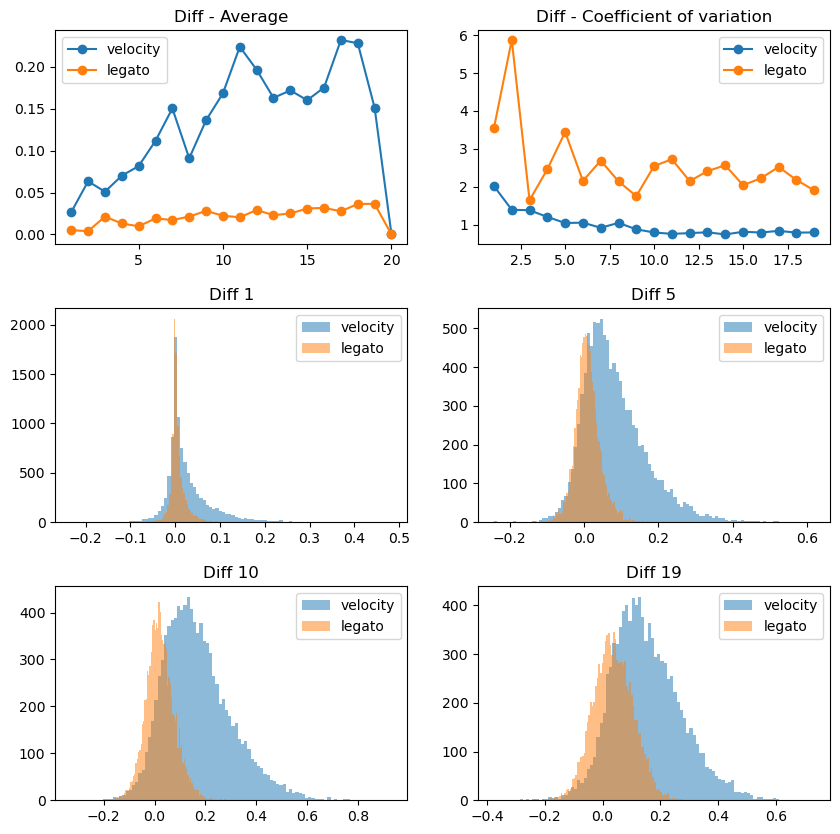

In [42]:
show(vel_groups, leg_groups)

0.027464373 0.003962355
0.06534389 0.002554436
0.052884 0.015949069
0.07262668 0.009386306
0.08641128 0.007475856
0.11581086 0.013473822
0.16952328 0.01302486
0.09775434 0.01654021
0.14355448 0.020714333
0.18375257 0.016668202
0.23993862 0.0146204205
0.20776586 0.021555128
0.17418289 0.016129766
0.18922615 0.019051779
0.16791657 0.022716498
0.19119486 0.024517646
0.25643256 0.019977994
0.24995068 0.028691825
0.16732642 0.028204955
0.0 0.0


/tmp/ipykernel_3112272/4273584610.py:21: RuntimeWarning: invalid value encountered in float_scalars
  vel_var = np.std(vel_diff) / vel_m
/tmp/ipykernel_3112272/4273584610.py:26: RuntimeWarning: invalid value encountered in float_scalars
  leg_var = np.std(leg_diff) / leg_m


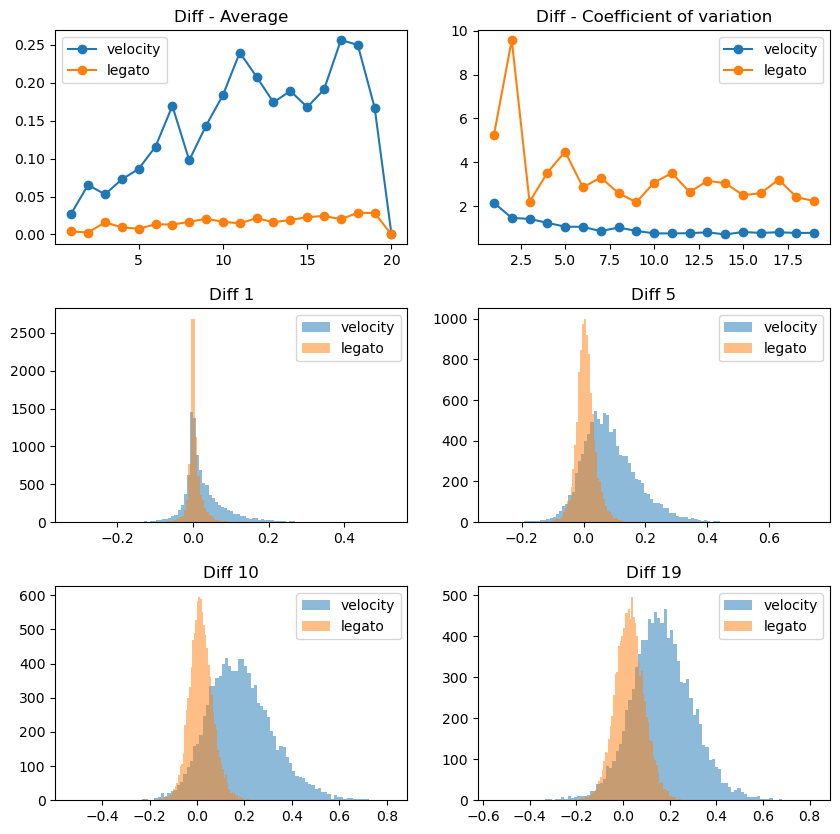

In [84]:
show(vel_groups, leg_groups)

In [23]:
[(i, j) for i in range(1, 3) for j in range(0, 2)]

[(1, 0), (1, 1), (2, 0), (2, 1)]